<a href="https://colab.research.google.com/github/Actulus/MI/blob/main/lab3/Lab3_MLP_StepBYStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MLP szerkezete:

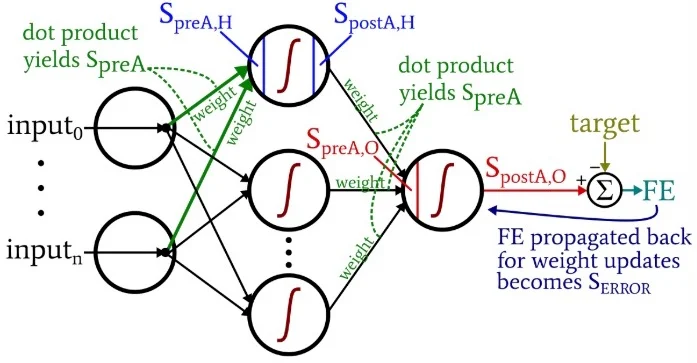

A NumPy könyvtárat széles körben használják a hálózat számításaihoz, a Pandas könyvtár pedig kényelmes módot biztosít edzési adatok importálására Excel fájlból.

In [2]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Amint azt már tudja, a logisztikus szigmoid funkciót használjuk az aktiváláshoz. Magára a logisztikus függvényre van szükségünk a posztaktivációs értékek számításához, a logisztikus függvény deriváltjára pedig a visszaterjesztéshez.

In [3]:
def sigmoidFunction(x):
    return 1.0/(1 + np.exp(-x))

def sigmoidFunctionDeriv(x):
    return sigmoidFunction(x) * (1 - sigmoidFunction(x))

Ezután kiválasztjuk a tanulási sebességet, a bemeneti réteg dimenzióját, a rejtett réteg dimenzióját és az epochák számát.

In [4]:
LR = 1

I_dim = 3
H_dim = 4

epoch_count = 1

Az np.random.uniform() függvény kitölti a mi két súlymátrixunkat –1 és +1 közötti véletlenszerű értékekkel. (Megjegyezzük, hogy a rejtett-kimeneti mátrix valójában csak egy tömb, mert csak egy kimeneti csomópontunk van.) Az np.random.seed(1) utasítás azt eredményezi, hogy a véletlen értékek a program minden egyes futtatásakor ugyanazok lesznek. A kezdeti súlyértékek jelentős hatással lehetnek a betanított hálózat végső teljesítményére, ezért ha azt szeretné felmérni, hogy más változók hogyan javítják vagy rontják a teljesítményt, törölheti ezt az utasítást, és ezáltal kiküszöbölheti a véletlenszerű súlyozás inicializálásának hatását.

Végül üres tömböket hozok létre a rejtett rétegben lévő elő- és utóaktiválási értékekhez.

In [5]:
#np.random.seed(1)
weights_ItoH = np.random.uniform(-1, 1, (I_dim, H_dim))
weights_HtoO = np.random.uniform(-1, 1, H_dim)

preActivation_H = np.zeros(H_dim)
postActivation_H = np.zeros(H_dim)

# **Képzési adatok importálása**

Importálom a betanítási adatokat az Excelből, elkülönítem a célértékeket az „output” oszlopban, eltávolítom az „output” oszlopot, konvertálom a betanítási adatokat NumPy mátrixba, és tárolom a képzési minták számát a training_count változóban.

In [9]:
path='/content/drive/My Drive/MI/lab3/MLP_Tdata.xlsx'
training_data = pd.read_excel(path)
target_output = training_data.output
training_data = training_data.drop(['output'], axis=1)
training_data = np.asarray(training_data)
training_count = len(training_data[:,0])

In [10]:
path='/content/drive/My Drive/MI/lab3/MLP_Vdata.xlsx'
validation_data = pd.read_excel(path)
validation_output = validation_data.output
validation_data = validation_data.drop(['output'], axis=1)
validation_data = np.asarray(validation_data)
validation_count = len(validation_data[:,0])

# **Feedforward feldolgozás**

Azok a számítások, amelyek kimeneti értéket állítanak elő, és amelyekben az adatok balról jobbra mozognak egy tipikus neurális-hálózati diagramon, a rendszer működésének „feedforward” részét alkotják.
Az első for ciklus több korszakot tesz lehetővé. Minden korszakon belül kiszámítunk egy kimeneti értéket (azaz a kimeneti csomópont utóaktiválási jelét) minden egyes mintához, és ezt a mintánkénti műveletet a második for ciklusban rögzíti. A harmadik for ciklusban külön-külön foglalkozunk minden egyes rejtett csomóponttal, a pontszorzat segítségével az előaktiválási jelet, az aktiváló funkcióval pedig az utólagos aktiválási jelet.

Ezt követően készen állunk a kimeneti csomópont előaktiválási jelének kiszámítására (ismét a pontszorzat használatával), és az aktiváló függvényt alkalmazzuk az utóaktiválási jel generálására. Ezután kivonjuk a célt a kimeneti csomópont utóaktiválási jeléből a végső hiba kiszámításához.

# **Visszaterjesztés**

Miután elvégeztük az előrecsatolási számításokat, ideje megcserélni az irányokat. A program visszaterjesztési részében a kimeneti csomóponttól a rejtett-kimeneti súlyok, majd a bemenet-rejtett súlyok felé haladunk, így magunkkal hozzuk azokat a hibainformációkat, amelyeket a hálózat hatékony betanításához használunk.
Két rétegű for ciklus van itt: egy a rejtett-kimeneti súlyokhoz, egy pedig a bemenet-rejtett súlyokhoz. Először generálunk SERROR-t, amelyre mind a gradientHtoO, mind a gradientItoH számításához szükségünk van, majd frissítjük a súlyokat a gradiens és a tanulási sebesség szorzatának kivonásával.

Figyelje meg, hogyan frissülnek a bemenet–rejtett súlyok a rejtett–kimeneti hurkon belül. Kezdjük azzal a hibajellel, amely az egyik rejtett csomóponthoz vezet vissza, majd ezt a hibajelzést kiterjesztjük az összes bemeneti csomópontra, amely ehhez az egyetlen rejtett csomóponthoz kapcsolódik.

Miután az adott rejtett csomóponthoz tartozó összes súlyozást (ItoH és HtoO egyaránt) frissítettük, visszalépünk, és újrakezdjük a következő rejtett csomóponttal.

Vegye figyelembe azt is, hogy az ItoH súlyok a HtoO súlyok előtt módosulnak. A gradientItoH kiszámításakor az aktuális HtoO súlyt használjuk, így nem akarjuk megváltoztatni a HtoO súlyokat a számítás elvégzése előtt.

In [11]:
#####################
#training
#####################
Errors = []
FEErrors = []
ize = list(range(training_count))
for epoch in range(epoch_count):
    for sample in range(training_count):
        for node in range(H_dim):
            preActivation_H[node] = np.dot(training_data[sample,:], weights_ItoH[:, node])
            postActivation_H[node] = sigmoidFunction(preActivation_H[node])

        preActivation_O = np.dot(postActivation_H, weights_HtoO)
        postActivation_O = sigmoidFunction(preActivation_O)

        FE = postActivation_O - target_output[sample]
        ize[sample] = ize[sample] * FE

        for H_node in range(H_dim):
            S_error = FE * sigmoidFunctionDeriv(preActivation_O)
            Errors.append(S_error)
            gradient_HtoO = S_error * postActivation_H[H_node]

            for I_node in range(I_dim):
                input_value = training_data[sample, I_node]
                gradient_ItoH = S_error * weights_HtoO[H_node] * sigmoidFunctionDeriv(preActivation_H[H_node]) * input_value

                weights_ItoH[I_node, H_node] -= LR * gradient_ItoH

            weights_HtoO[H_node] -= LR * gradient_HtoO


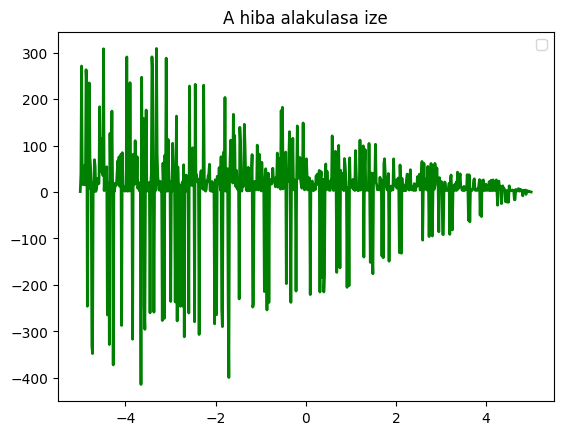

In [12]:
import matplotlib.pyplot as plt

ize.reverse()
revError = ize
t = np.linspace(-5, 5, num=training_count)
plt.plot(t, revError, "g", linewidth = 2)
plt.legend()

plt.title('A hiba alakulasa ize')
plt.show()

In [13]:
#####################
#validation
#####################
correct_classification_count = 0
for sample in range(validation_count):
    for node in range(H_dim):
        preActivation_H[node] = np.dot(validation_data[sample,:], weights_ItoH[:, node])
        postActivation_H[node] = sigmoidFunction(preActivation_H[node])

    preActivation_O = np.dot(postActivation_H, weights_HtoO)
    postActivation_O = sigmoidFunction(preActivation_O)

    if postActivation_O > 0.5:
        output = 1
    else:
        output = 0

    if output == validation_output[sample]:
        correct_classification_count += 1


In [14]:
print('Percentage of correct classifications:')
print(correct_classification_count*100/validation_count)

Percentage of correct classifications:
89.96655518394648


# **Megoldandó feladatok:**

1). Tanulmányozzuk a háló tanítását különböző tanítási együtthatókra. A két rétegre a tanítási együtthatókat külön-külön kell változtatni és grafikusan ábrázolni a hibát (költségfüggvényt) a tanító halmazra illetve a teszthalmazra.

 2) Tanulmányozzuk a háló viselkedését a rejtett rétegben levő neuronok számának a függvényében (ábrázolni a hibát a tanító és a teszthalmazra különböző neuron számra).

3) Különböző típusú aktiváló függvényt alkalmazva (legalább három típusú aktivációs függvényre) végezzük el a tanítást és a tesztelést. Melyik a jobb és miért?


# **Javasolt pluszpontos feladatok:**

4) A súlyok tanítására alkalmazzunk momentum kiegészítő tagot.

5) Az L1 és L2 regularizációs módszereket alkalmazva csökkentsük a neuroháló méretét, kivágva  a rejtett rétegből azokat a neuronokat, amelyek kimenete miden egyes elemre a tanítóhalmazból nulla körüli értéket vesz fel.

A mérések során tanulmanyozzuk a tultanítást és az eredményt ábrázoljuk grafiusan (hiba  ábrázolása a tanító és teszthalmazra).